Define the threshold that will be used for each glacier each year

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely 
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])
dc_gdf = dc_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [4]:
# open the base data for each glacier, format into a single df
c=0
all_series = []
for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>10: continue
    
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    o3region = row['o3region']
    
    # if o1region!='15':continue
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific cloud info as a pd.Series, append to list
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'debris_waterthresholds_accaqa.csv')#188,137
    df_g = pd.read_csv(path_open, index_col=None, header=0).squeeze()
    df_g['o3_region'] = str(int(o3region))
    df_g['o2_region'] = str(o2region)
    df_g['o1_region'] = str(o1region)
    df_g['rgi_id'] = str(rgi_id)
    all_series.append(df_g)

# format into df
df_all = pd.concat(all_series).reset_index(drop=True)


# format to numeric dtypes
all_cols = df_all.columns
for c in all_cols:
    if c in ['rgi_id', 'o1_region', 'o2_region', 'o3_region']: continue
    df_all[c] = df_all[c].astype(float)
    
# add columns that has difference
df_all['difference'] = df_all['otsu_threshold_exclude0'] - df_all['otsu_threshold_include0']

# merge with glacier area
print("All done!")

100 of 769 RGI2000-v7.0-G-14-06944
200 of 769 RGI2000-v7.0-G-13-71307
300 of 769 RGI2000-v7.0-G-14-15108
400 of 769 RGI2000-v7.0-G-14-32564
500 of 769 RGI2000-v7.0-G-15-01330
600 of 769 RGI2000-v7.0-G-15-05352
700 of 769 RGI2000-v7.0-G-15-08609
All done!


In [5]:
# df_all

1

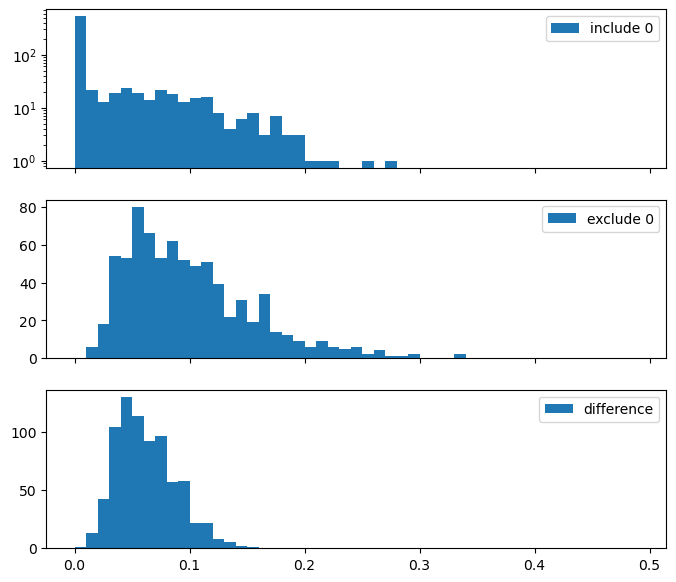

In [6]:
# get average threshs for each glacier
df_rgi = df_all.groupby("rgi_id").median(numeric_only=True).reset_index()

# histograms
fig,axs = plt.subplots(3,1, figsize=(8,7), sharex=True)
axs[0].hist(df_rgi['otsu_threshold_include0'], bins=np.arange(0,0.5,0.01), label='include 0')
axs[1].hist(df_rgi['otsu_threshold_exclude0'], bins=np.arange(0,0.5,0.01), label='exclude 0')
axs[2].hist(df_rgi['difference'], bins=np.arange(0,0.5,0.01), label='difference')
axs[0].set_yscale('log')
# axs[1].set_yscale('log')
axs[0].legend()
axs[1].legend()
axs[2].legend()
1

Text(0.5, 1.0, 'All annual obs')

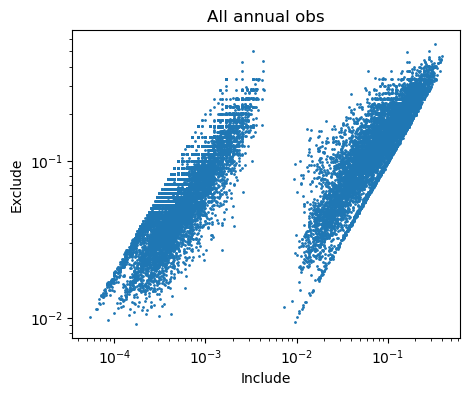

In [7]:
# scatterplot of including vs excluding
fig,axs = plt.subplots(figsize=(5,4))
axs.scatter(df_all['otsu_threshold_include0'], df_all['otsu_threshold_exclude0'], s=1)
axs.set_xlabel("Include")
axs.set_ylabel("Exclude")
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_title("All annual obs")

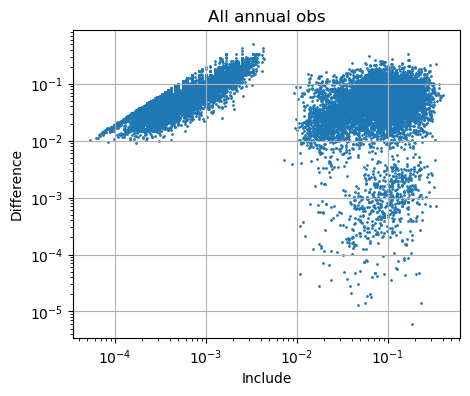

In [8]:
# scatterplot of difference
fig,axs = plt.subplots(figsize=(5,4))
axs.scatter(df_all['otsu_threshold_include0'], df_all['difference'], s=1)
axs.set_xlabel("Include")
axs.set_ylabel("Difference")
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_title("All annual obs")

axs.grid(zorder=1)

Text(0.5, 1.0, 'Glacier averages')

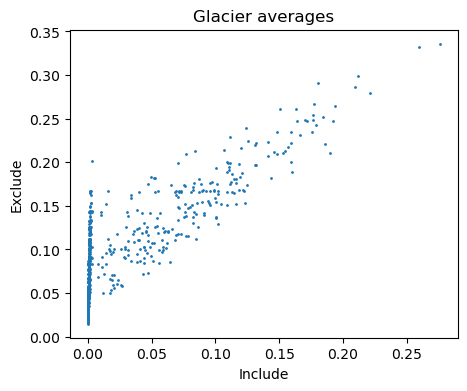

In [9]:
# scatterplot of including vs excluding
fig,axs = plt.subplots(figsize=(5,4))
axs.scatter(df_rgi['otsu_threshold_include0'], df_rgi['otsu_threshold_exclude0'], s=1)
axs.set_xlabel("Include")
axs.set_ylabel("Exclude")
# axs.set_yscale('log')
axs.set_title("Glacier averages")

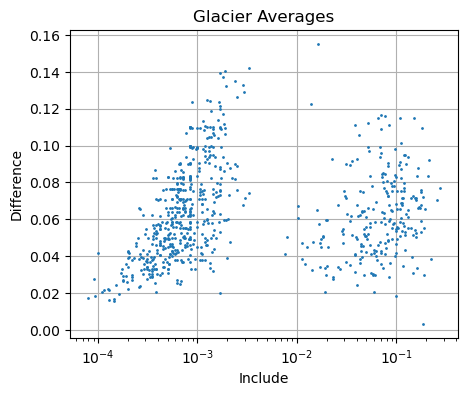

In [10]:
# scatterplot of difference
fig,axs = plt.subplots(figsize=(5,4))
axs.scatter(df_rgi['otsu_threshold_include0'], df_rgi['difference'], s=1, zorder=2)
axs.set_xlabel("Include")
axs.set_ylabel("Difference")
axs.set_xscale('log')
# axs.set_yscale('log')
axs.set_title("Glacier Averages")
axs.grid(zorder=1)

## We want to find the best threshold to use for each glacier each year.

Ideally, we would just take the original threshold found from Otsu's method, including background 0s, and use that.

But if this value is less than 0.1 (what we treat as the absolute minimum), we assume that it's not a reliable thresholder. Because it is indicating that there is actually not much water

So in years where the original otsu threshold is <0.1, then we will override it with the average of the thresholds found in other years on that glacier (that are >=0.1)

In [11]:
# define minimum threshold here first
minimum_thresh = 0.1

# list to hold values
pass1 = []

# iterate through each row (each year of each glacier)
for idx, row in df_all.iterrows():
    
    rgi_id_i = row['rgi_id']
    
    if row['otsu_threshold_include0']>=minimum_thresh:
        new_thresh = row['otsu_threshold_include0']
        
    else:
        # subset to usable include0 thresholds from this glacier
        subset = df_all[df_all['rgi_id']==rgi_id_i]
        subset = subset[subset['otsu_threshold_include0']>=minimum_thresh]
        
        # find average (if exists) and use that. else, -9999
        if len(subset)==0:
            new_thresh = -9999
        elif np.isnan(subset['otsu_threshold_include0'].values).all():
            new_thresh = -9999
        else:
            new_thresh = np.nanmean(subset['otsu_threshold_include0'])
    pass1.append(new_thresh)
    
df_all['threshold_pass1'] = pass1
# df_all.head(2)
len(df_all[ df_all['threshold_pass1']<minimum_thresh ])

11628

There will be some cases where we still do not have good data for a glacier in some years. For example, if the original threshold found was less than 0.1 for every single year.

This means that the entire glacier likely never has much of any water. We will calculate the average otsu threshold found for that glacier when removing the background 0s from the otsu calculation. The threshold found when doing this step is always higher than if we keep the 0s in the calculation.

In [12]:
pass2 = []
for idx, row in df_all.iterrows():
    
    rgi_id_i = row['rgi_id']
    
    # if we already have a suitable threshold, use it
    if row['threshold_pass1']>=minimum_thresh:
        new_thresh = row['threshold_pass1']
        
    else:
        # subset to usable exclude0 thresholds from this glacier
        subset = df_all[df_all['rgi_id']==rgi_id_i]
        subset = subset[subset['otsu_threshold_exclude0']>=minimum_thresh]
        
        # find average (if exists) and use that. else, -9999
        if len(subset)==0:
            new_thresh = -9999
        elif np.isnan(subset['otsu_threshold_exclude0'].values).all():
            new_thresh = -9999
        else:
            new_thresh = np.nanmean(subset['otsu_threshold_exclude0'])
    
    pass2.append(new_thresh)
df_all['threshold_pass2'] = pass2
# df_all.head(2)
len(df_all[ df_all['threshold_pass2']<minimum_thresh ])

900

In a very few number of cases, we still don't have a valid threshold to use. So we will fill in with a globally-defined average thresholding value. (~0.15 in our case)

In [13]:
# lastly, fill the remaining data with a global average
all_good = df_all[df_all['threshold_pass2']>=minimum_thresh]
avg_good = np.nanmean(all_good['threshold_pass2'])
print(avg_good)

pass3 = []
for idx, row in df_all.iterrows():
    
    rgi_id_i = row['rgi_id']
    
    # if we already have a suitable threshold, use it
    if row['threshold_pass2']>=minimum_thresh:
        new_thresh = row['threshold_pass2']
        
    else:
        new_thresh = avg_good
    pass3.append(new_thresh)
df_all['threshold_pass3'] = pass3

0.13921227180000018


In [14]:
# lets save these final thresholds to a csv to use later
df_out = df_all[['rgi_id', 'year', 'threshold_pass3']].rename({'threshold_pass3':"final_threshold"}, axis=1)
df_out['final_threshold'] = np.round(df_out['final_threshold'],6)
path_out = os.path.join(folder_datasets, 'final_otsuthresholds_188_accaqa.csv')#188,137
df_out.to_csv(path_out, index=False)

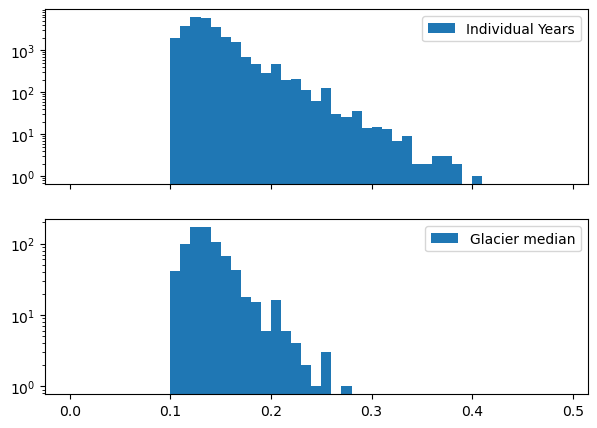

In [15]:
# figure to visualize the final thresholds
df_rgi = df_all.groupby("rgi_id").median(numeric_only=True).reset_index()

fig,axs = plt.subplots(2,1, figsize=(7,5), sharex=True)
axs[0].hist(df_all['threshold_pass3'], bins=np.arange(0,0.5,0.01), label='Individual Years')
axs[1].hist(df_rgi['threshold_pass3'], bins=np.arange(0,0.5,0.01), label='Glacier median')

axs[0].legend()
axs[1].legend()
axs[0].set_yscale('log')
axs[1].set_yscale('log')


In [16]:
# df_all[df_all['rgi_id']=='RGI2000-v7.0-G-14-11612']